Load and process results

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


    
#load csv
raw_df = pd.read_csv("./results/boat_race_results.csv")

raw_df["date"] = pd.to_datetime(raw_df["date"])

raw_df["winning_time"] = pd.to_timedelta("00:" + raw_df["winning_time"])
raw_df["winning_time"] = raw_df["winning_time"].dt.total_seconds()

raw_df["time_to_clear_water"] = pd.to_timedelta("00:" + raw_df["time_to_clear_water"])
raw_df["time_to_clear_water"] = raw_df["time_to_clear_water"].dt.total_seconds()

raw_df["time_to_mile_post"] = pd.to_timedelta("00:" + raw_df["time_to_mile_post"])
raw_df["time_to_mile_post"] = raw_df["time_to_mile_post"].dt.total_seconds()

raw_df["speed_to_mile_post"] = 1609.34 / raw_df["time_to_mile_post"]
raw_df["speed_to_finish"] = 6800 / raw_df["winning_time"]

raw_df["fast_start_factor"] = raw_df["speed_to_mile_post"]/raw_df["speed_to_finish"]

raw_df["surrey_win"] = (
    ((raw_df["winner"] == "Cambridge") & (raw_df["ox_station"] == "m")) |
    ((raw_df["winner"] == "Oxford") & (raw_df["ox_station"] == "s"))
)
raw_df["year"] = raw_df["date"].dt.year      
display(raw_df)


,date,winner,winning_time,margin,time_to_clear_water,time_to_mile_post,notes,ox_station,speed_to_mile_post,speed_to_finish,fast_start_factor,surrey_win,year
0,1999-04-03,Cambridge,1001.0,3.5000,430.0,217.0,NaN,m,7.416313,6.793207,1.091725,True,1999
1,2000-03-25,Oxford,1084.0,3.0000,850.0,221.0,NaN,m,7.282081,6.273063,1.160849,False,2000
2,2001-03-24,Cambridge,1199.0,2.5000,535.0,298.0,clash and restart before mile post,m,5.400470,5.671393,0.952230,True,2001
3,2002-03-30,Oxford,1014.0,0.7500,1014.0,218.0,NaN,s,7.382294,6.706114,1.100830,True,2002
4,2003-04-06,Oxford,1086.0,0.0160,1086.0,235.0,NaN,m,6.848255,6.261510,1.093707,False,2003
5,2004-03-28,Cambridge,1127.0,6.0000,263.0,234.0,clash causing ox to lose a length,s,6.877521,6.033718,1.139848,False,2004
6,2005-03-27,Oxford,1002.0,2.0000,616.0,220.0,NaN,s,7.315182,6.786427,1.077914,True,2005
7,2006-04-02,Oxford,1106.0,5.0000,556.0,223.0,NaN,s,7.216771,6.148282,1.173787,True,2006
8,2007-04-07,Cambridge,1069.0,1.2500,850.0,225.0,NaN,s,7.152622,6.361085,1.124434,False,2007
9,2008-03-29,Oxford,1253.0,6.0000,755.0,248.0,NaN,m,6.489274,5.426975,1.195744,False,2008


Call API and append weather data


In [277]:
import pandas as pd
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup cached session for efficiency & retries
cache_session = requests_cache.CachedSession('.cache', expire_after=36000000)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
client = openmeteo_requests.Client(session=retry_session)

def fetch_weather_at_2pm(lat, lon, when, variables=None):
    """
    Fetch hourly weather from Open-Meteo and return the row for 2 pm local time
    on the same date as `when`.
    """
    if variables is None:
        variables = ["temperature_2m", "wind_speed_10m", "wind_direction_10m"]

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": when.date().isoformat(),
        "end_date": when.date().isoformat(),
        "hourly": variables,
        "timezone": "auto",  # ensures times are aligned with local timezone
    }

    responses = client.weather_api(url, params=params)
    resp = responses[0]
    hourly = resp.Hourly()

    n = hourly.Variables(0).ValuesAsNumpy().shape[0]
    times = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        periods=n,
        freq=pd.Timedelta(seconds=hourly.Interval()),
    )

    data = {var: hourly.Variables(i).ValuesAsNumpy() for i, var in enumerate(variables)}
    df = pd.DataFrame(data, index=times)

    # Build target datetime: same date as `when`, but fixed to 14:00
    target_time = pd.to_datetime(
        when.date().isoformat() + " 14:00"
    ).tz_localize(df.index.tz)  # match timezone of API output

    # Find closest hourly record to 14:00
    row = df.iloc[df.index.get_indexer([target_time], method="nearest")]
    return row.to_dict("records")[0]


weather_records = []

for idx, row in raw_df.iterrows():
    lat = 51.477331
    lon = -0.225
    end_time = row["date"]

    try:
        weather = fetch_weather_at_2pm(lat, lon, end_time)
    except Exception as e:
        print(f"Weather fetch failed for {idx}: {e}")
        weather = {var: None for var in ["temperature_2m", "wind_speed_10m", "wind_direction_10m"]}

    weather_records.append(weather)

# merge into df
weather_df = pd.DataFrame(weather_records, index=raw_df.index)
data_with_weather = pd.concat([raw_df, weather_df], axis=1)
data_with_weather["wind_bearing"] = (data_with_weather["wind_direction_10m"] + 180) % 360
data_with_weather = data_with_weather.rename(columns={"wind_speed_10m": "wind_speed"})

display(data_with_weather[4:5])




,date,winner,winning_time,margin,time_to_clear_water,time_to_mile_post,notes,ox_station,speed_to_mile_post,speed_to_finish,fast_start_factor,surrey_win,year,temperature_2m,wind_speed,wind_direction_10m,wind_bearing
4,2003-04-06,Oxford,1086.0,0.016,1086.0,235.0,NaN,m,6.848255,6.26151,1.093707,False,2003,8.792999,16.981165,21.124796,201.124796


Calculate wind to stream angles and velocity components

In [278]:
flow_bearings = {
    "craven": 318.7,
    "mile_post": 0.0,
    "harrods": 329.3,
    "st_pauls": 230.0,
    "bandstand": 194.6,
}


def wind_to_stream(wind_bearing, flow_bearing):
    if pd.isna(wind_bearing):
        return np.nan
    angle_diff = np.abs((wind_bearing - flow_bearing))
    return min(angle_diff, 360 - angle_diff)


for landmark, bearing in flow_bearings.items():
    data_with_weather[f"wind_to_stream_angle_{landmark}"] = data_with_weather["wind_bearing"].apply(
        lambda wb: wind_to_stream(wb, bearing)
    )
    data_with_weather[f"wind_component_{landmark}"] = (
        data_with_weather["wind_speed"]
        * np.cos(np.deg2rad(data_with_weather[f"wind_to_stream_angle_{landmark}"]))
    )

display(data_with_weather)

,date,winner,winning_time,margin,time_to_clear_water,time_to_mile_post,notes,ox_station,speed_to_mile_post,speed_to_finish,...,wind_to_stream_angle_craven,wind_component_craven,wind_to_stream_angle_mile_post,wind_component_mile_post,wind_to_stream_angle_harrods,wind_component_harrods,wind_to_stream_angle_st_pauls,wind_component_st_pauls,wind_to_stream_angle_bandstand,wind_component_bandstand
0,1999-04-03,Cambridge,1001.0,3.5000,430.0,217.0,NaN,m,7.416313,6.793207,...,18.955211,2.745023,60.255211,1.439996,29.555211,2.524753,69.744789,1.004822,105.144789,-0.758282
1,2000-03-25,Oxford,1084.0,3.0000,850.0,221.0,NaN,m,7.282081,6.273063,...,83.736188,1.862721,42.436188,12.600008,73.136188,4.952696,172.436188,-16.923954,152.163812,-15.096980
2,2001-03-24,Cambridge,1199.0,2.5000,535.0,298.0,clash and restart before mile post,m,5.400470,5.671393,...,82.040725,2.267441,123.340725,-9.000004,92.640725,-0.754448,6.659275,16.264576,42.059275,12.157694
3,2002-03-30,Oxford,1014.0,0.7500,1014.0,218.0,NaN,s,7.382294,6.706114,...,70.877744,5.017249,29.577744,13.320012,60.277744,7.593549,159.577744,-14.353217,165.022256,-14.795536
4,2003-04-06,Oxford,1086.0,0.0160,1086.0,235.0,NaN,m,6.848255,6.261510,...,117.575204,-7.860793,158.875204,-15.839991,128.175204,-10.495519,28.875204,14.869958,6.524796,16.871174
5,2004-03-28,Cambridge,1127.0,6.0000,263.0,234.0,clash causing ox to lose a length,s,6.877521,6.033718,...,96.165723,-1.276552,54.865723,6.840014,85.565723,0.918930,175.134277,-11.842621,139.734277,-9.069256
6,2005-03-27,Oxford,1002.0,2.0000,616.0,220.0,NaN,s,7.315182,6.786427,...,113.059043,-3.910178,154.359043,-9.000004,123.659043,-5.533132,24.359043,9.094397,11.040957,9.798324
7,2006-04-02,Oxford,1106.0,5.0000,556.0,223.0,NaN,s,7.216771,6.148282,...,99.104291,-5.452454,57.804291,18.359988,88.504291,0.899441,172.195709,-34.139436,136.795709,-25.117474
8,2007-04-07,Cambridge,1069.0,1.2500,850.0,225.0,NaN,s,7.152622,6.361085,...,102.230666,-2.181239,143.530666,-8.279989,112.830666,-3.995038,13.530666,10.010477,21.869334,9.555289
9,2008-03-29,Oxford,1253.0,6.0000,755.0,248.0,NaN,m,6.489274,5.426975,...,47.640103,19.768491,6.340103,29.160006,37.040103,23.419161,136.340103,-21.225640,171.740103,-29.035099


Drop anomalous 2001 results

In [279]:
data_with_weather_2001_dropped = data_with_weather.drop(2, axis=0)


Helper function to make a scatter and add correlation

In [280]:
# Helper function to make a scatter and add correlation
def scatter_with_corr(ax, df, x, y, x_label, y_label, title):
    ax.scatter(df[x], df[y], alpha=0.7, edgecolors="k")
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if df[[x, y]].notna().all().all():
        r = df[x].corr(df[y])
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )

Plot influence of wind at various points on course on fast start factor

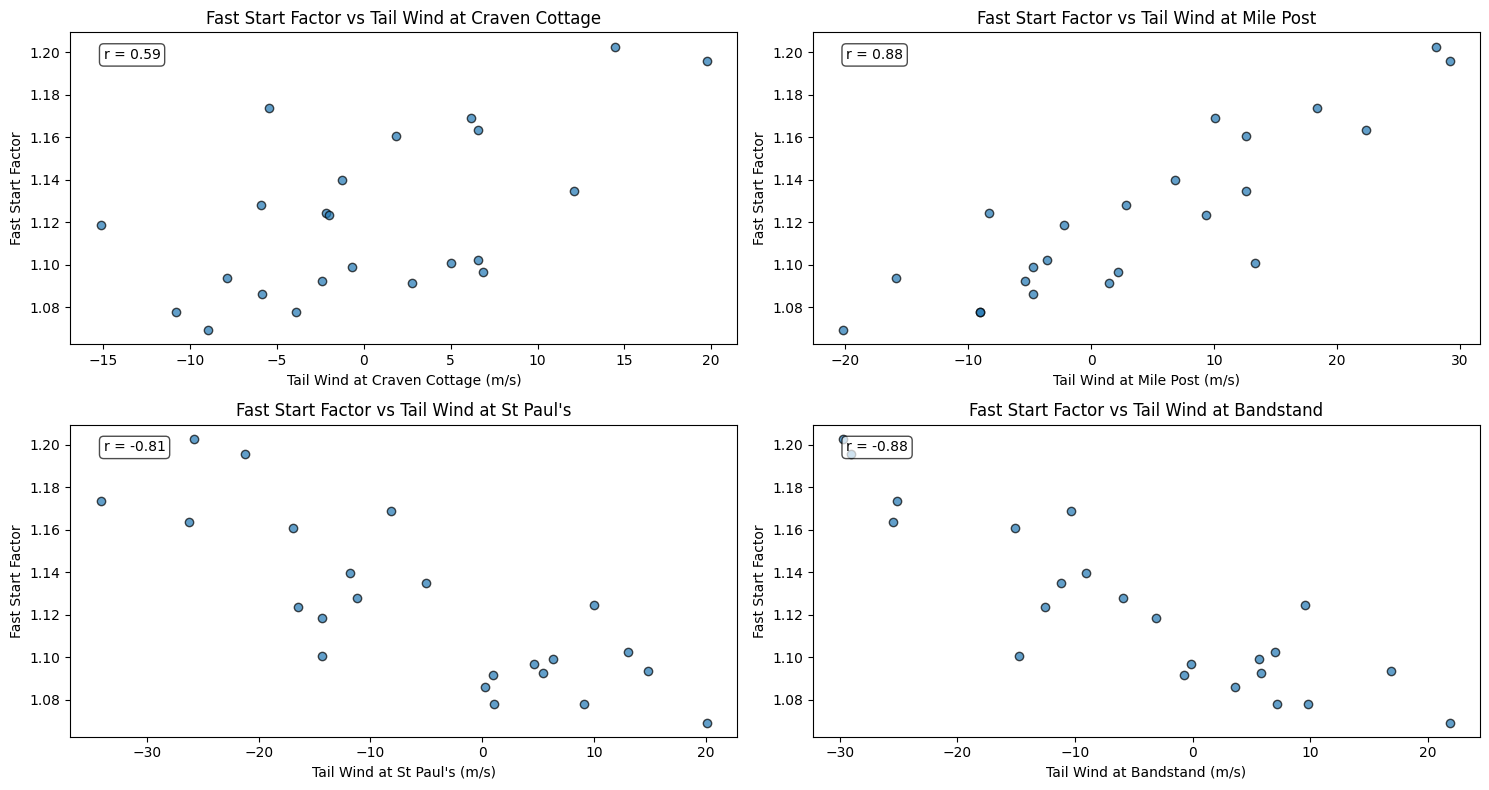

In [281]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# First scatter
scatter_with_corr(
    axes[0, 1],
    data_with_weather_2001_dropped,
    "wind_component_mile_post", "fast_start_factor",
    "Tail Wind at Mile Post (m/s)", "Fast Start Factor",
    "Fast Start Factor vs Tail Wind at Mile Post"
)

# Second scatter
scatter_with_corr(
    axes[0, 0],
    data_with_weather_2001_dropped,
    "wind_component_craven", "fast_start_factor",
    "Tail Wind at Craven Cottage (m/s)", "Fast Start Factor",
    "Fast Start Factor vs Tail Wind at Craven Cottage"
)


# Fifth scatter
scatter_with_corr(
    axes[1, 1],
    data_with_weather_2001_dropped,
    "wind_component_bandstand", "fast_start_factor",
    "Tail Wind at Bandstand (m/s)", "Fast Start Factor",
    "Fast Start Factor vs Tail Wind at Bandstand"
)

# Sixth scatter
scatter_with_corr(
    axes[1, 0],
    data_with_weather_2001_dropped,
    "wind_component_st_pauls", "fast_start_factor",
    "Tail Wind at St Paul's (m/s)", "Fast Start Factor",
    "Fast Start Factor vs Tail Wind at St Paul's"
)

plt.tight_layout()
plt.show()



Correct fast start factor for tailwind on the mile post stretch

In [282]:
import statsmodels.api as sm


def correct_for_wind(df, metric, wind_col, reference=0.0):
    """
    Correct a metric for wind speed using linear regression.
    
    df: DataFrame with metric and wind component
    metric: str,
    wbt_col: str
    reference: float, reference WBT for correction
    
    Returns: Series with corrected values
    """
    mask = df[[metric, wind_col]].dropna()
    if mask.empty:
        return pd.Series([None]*len(df), index=df.index)
    
    X = sm.add_constant(mask[wind_col])
    y = mask[metric]
    model = sm.OLS(y, X).fit()
    
    beta = model.params[wind_col]
    intercept = model.params["const"]
    
    # corrected = observed - beta * (WBT - reference)
    corrected = df[metric] - beta * (df[wind_col] - reference)
    return corrected

# apply correction
data_with_weather_2001_dropped["fast_start_factor_mile_post_wind_corrected"] = correct_for_wind(
    data_with_weather_2001_dropped, "fast_start_factor", "wind_component_mile_post", reference=0
)


display(data_with_weather_2001_dropped.head())

,date,winner,winning_time,margin,time_to_clear_water,time_to_mile_post,notes,ox_station,speed_to_mile_post,speed_to_finish,...,wind_component_craven,wind_to_stream_angle_mile_post,wind_component_mile_post,wind_to_stream_angle_harrods,wind_component_harrods,wind_to_stream_angle_st_pauls,wind_component_st_pauls,wind_to_stream_angle_bandstand,wind_component_bandstand,fast_start_factor_mile_post_wind_corrected
0,1999-04-03,Cambridge,1001.0,3.500,430.0,217.0,NaN,m,7.416313,6.793207,...,2.745023,60.255211,1.439996,29.555211,2.524753,69.744789,1.004822,105.144789,-0.758282,1.088037
1,2000-03-25,Oxford,1084.0,3.000,850.0,221.0,NaN,m,7.282081,6.273063,...,1.862721,42.436188,12.600008,73.136188,4.952696,172.436188,-16.923954,152.163812,-15.096980,1.128578
3,2002-03-30,Oxford,1014.0,0.750,1014.0,218.0,NaN,s,7.382294,6.706114,...,5.017249,29.577744,13.320012,60.277744,7.593549,159.577744,-14.353217,165.022256,-14.795536,1.066714
4,2003-04-06,Oxford,1086.0,0.016,1086.0,235.0,NaN,m,6.848255,6.261510,...,-7.860793,158.875204,-15.839991,128.175204,-10.495519,28.875204,14.869958,6.524796,16.871174,1.134277
5,2004-03-28,Cambridge,1127.0,6.000,263.0,234.0,clash causing ox to lose a length,s,6.877521,6.033718,...,-1.276552,54.865723,6.840014,85.565723,0.918930,175.134277,-11.842621,139.734277,-9.069256,1.122329


Investigate effect of tailwind at mile post on winning margin and time to clear water

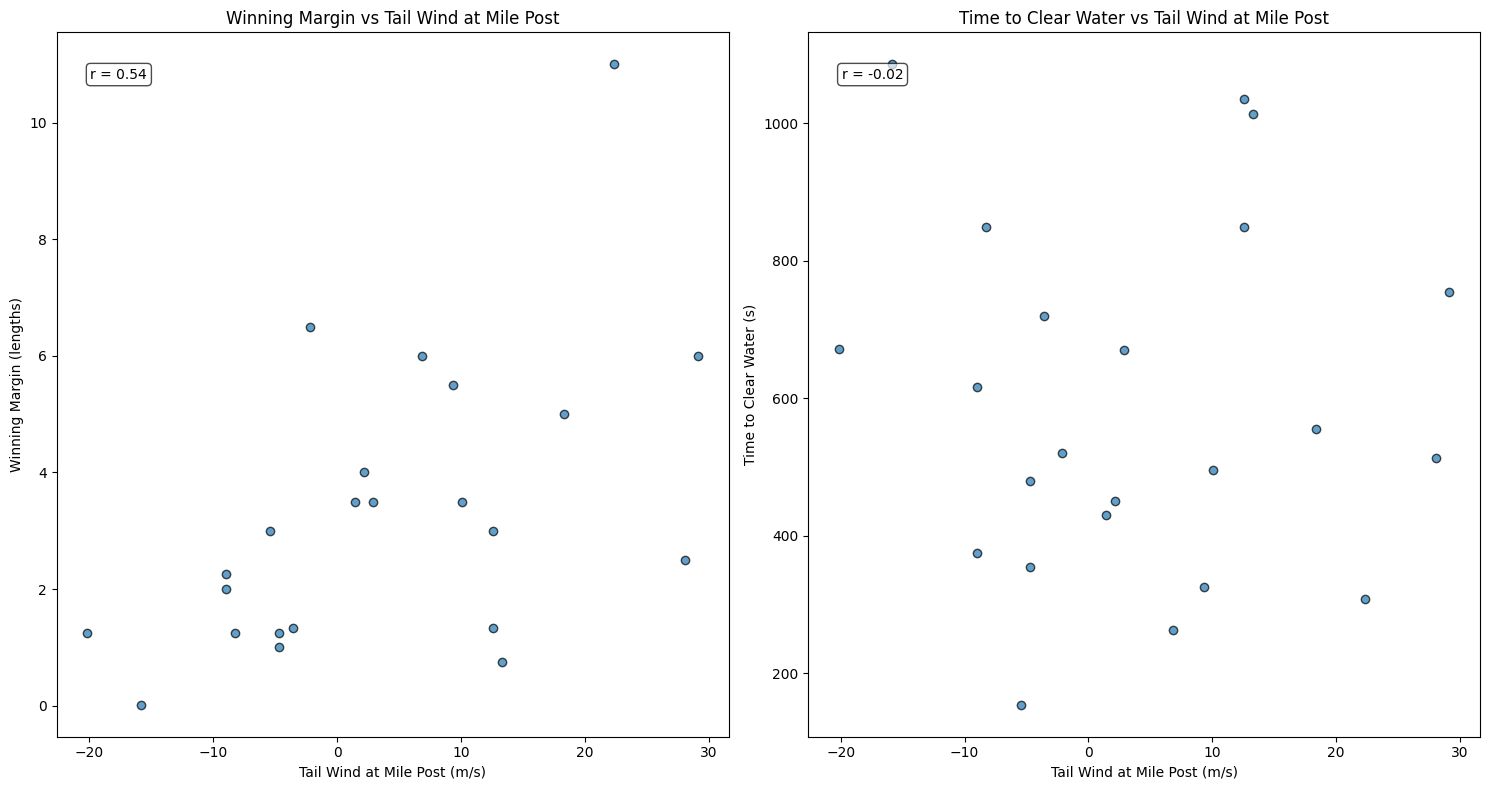

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# First scatter on left
scatter_with_corr(
    axes[0],
    data_with_weather_2001_dropped,
    "wind_component_mile_post", "margin",
    "Tail Wind at Mile Post (m/s)", "Winning Margin (lengths)",
    "Winning Margin vs Tail Wind at Mile Post"
)

# Second scatter on right
scatter_with_corr(
    axes[1],
    data_with_weather_2001_dropped,
    "wind_component_mile_post", "time_to_clear_water",
    "Tail Wind at Mile Post (m/s)", "Time to Clear Water (s)",
    "Time to Clear Water vs Tail Wind at Mile Post"
)

plt.tight_layout()
plt.show()


Define helper function for plotting with coloured points

In [284]:
def scatter_with_corr_coloured(ax, df, x, y, x_label, y_label, title, color_var=None):
    sc = ax.scatter(
        df[x],
        df[y],
        c=df[color_var] if color_var else None,
        cmap="viridis",       # choose a colormap (e.g. "plasma", "coolwarm")
        alpha=0.7,
        edgecolors="k"
    )
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Add colorbar only once per figure if coloring is used
    if color_var:
        fig.colorbar(sc, ax=ax, label=color_var)

    if df[[x, y]].notna().all().all():
        r = df[x].corr(df[y])
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )

Plot trend over time of fast start factor

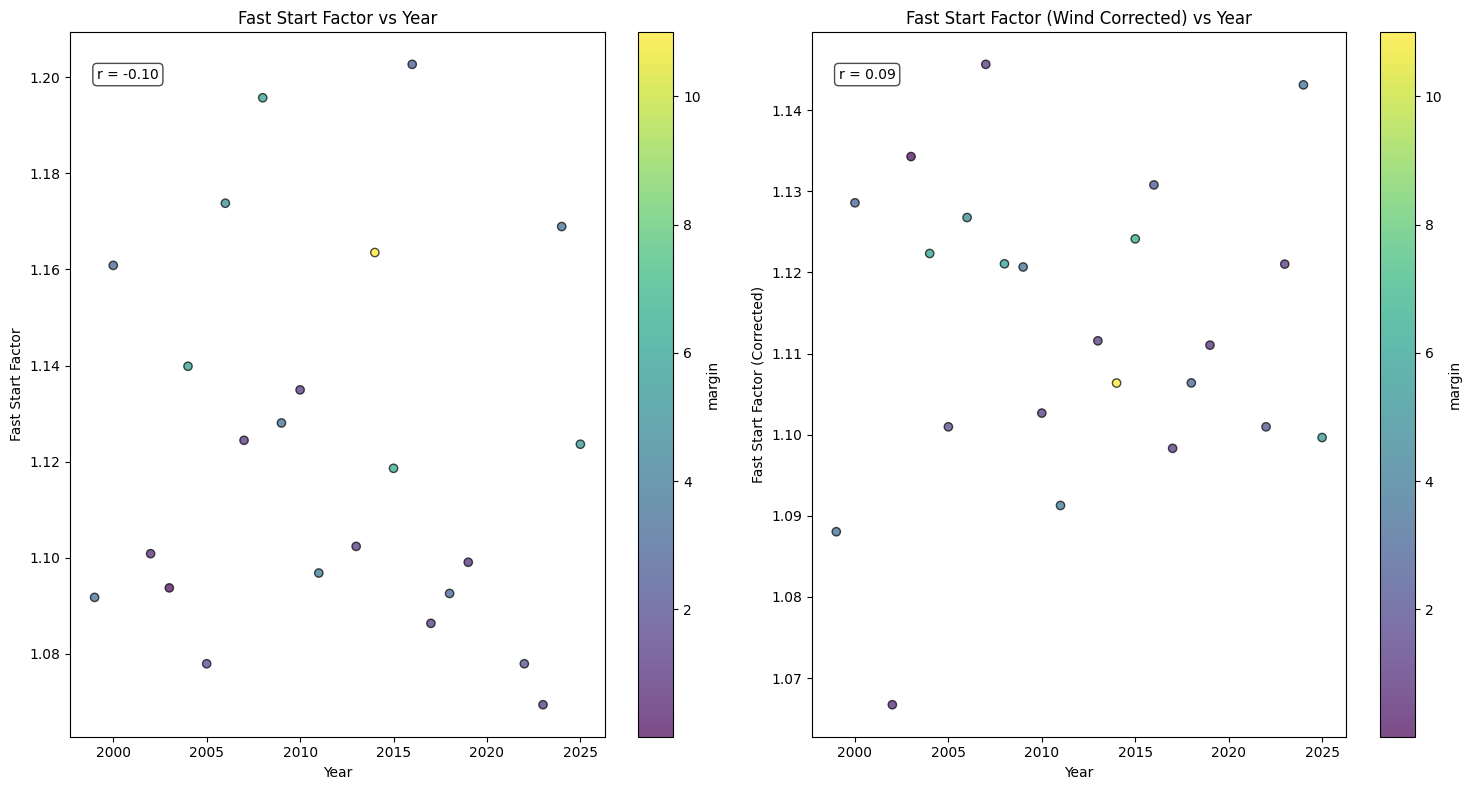

In [285]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))


# First scatter on left
scatter_with_corr_coloured(
    axes[0],
    data_with_weather_2001_dropped,
    "year", "fast_start_factor",
    "Year", "Fast Start Factor",
    "Fast Start Factor vs Year",
    color_var="margin"
)

# Second scatter on right
scatter_with_corr_coloured(
    axes[1],
    data_with_weather_2001_dropped,
    "year", "fast_start_factor_mile_post_wind_corrected",
    "Year", "Fast Start Factor (Corrected)",
    "Fast Start Factor (Wind Corrected) vs Year",
    color_var="margin"
)

plt.tight_layout()
plt.show()


Plot trend over time in winning time and time to clear water

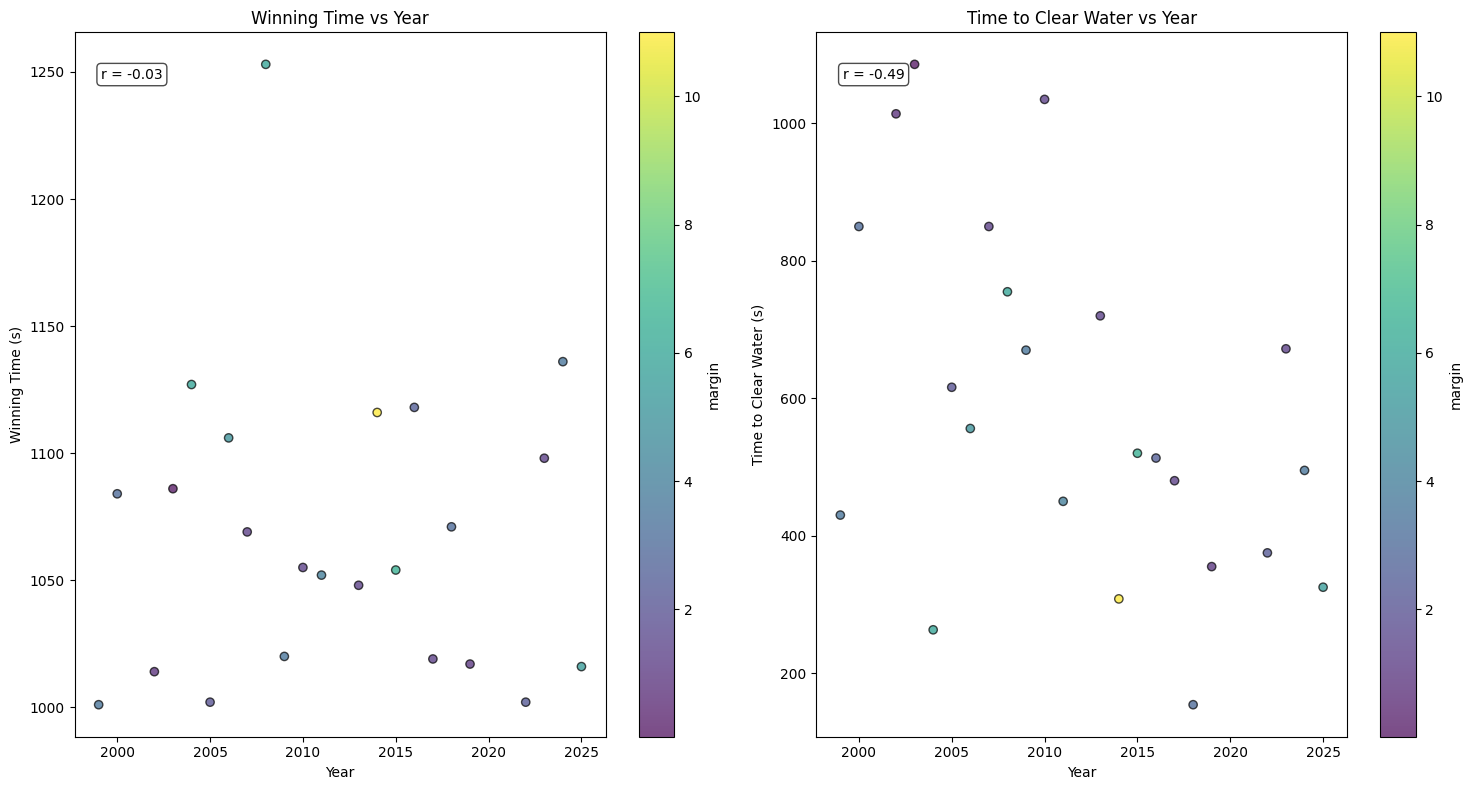

In [286]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))


# First scatter on left
scatter_with_corr_coloured(
    axes[0],
    data_with_weather_2001_dropped,
    "year", "winning_time",
    "Year", "Winning Time (s)",
    "Winning Time vs Year",
    color_var="margin"
)

# Second scatter on right
scatter_with_corr_coloured(
    axes[1],
    data_with_weather_2001_dropped,
    "year", "time_to_clear_water",
    "Year", "Time to Clear Water (s)",
    "Time to Clear Water vs Year",
    color_var="margin"
)

plt.tight_layout()
plt.show()


Investigate effect of fast start factor on winning margin and time to clear water

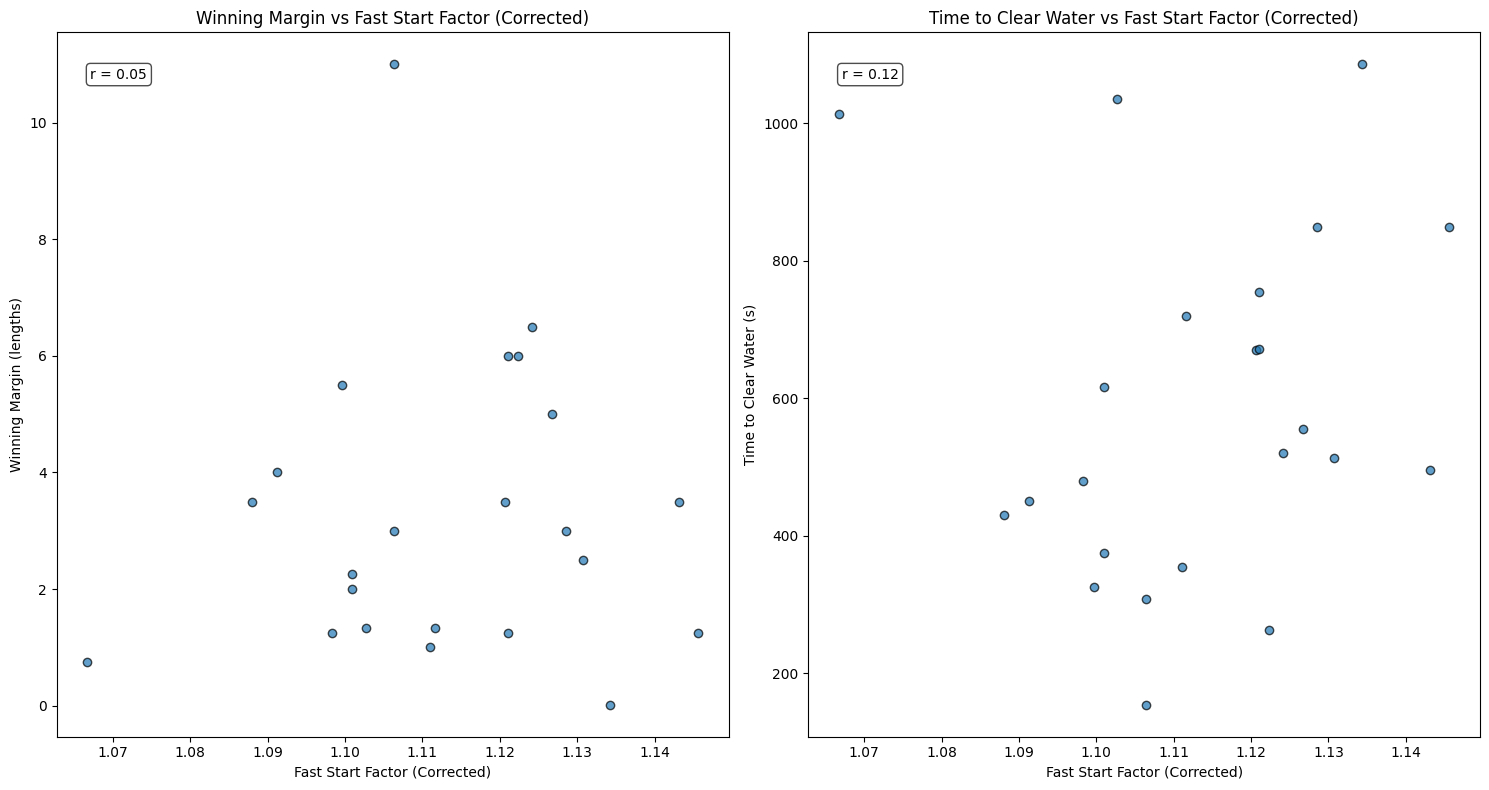

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# First scatter on left
scatter_with_corr(
    axes[0],
    data_with_weather_2001_dropped,
    "fast_start_factor_mile_post_wind_corrected", "margin",
    "Fast Start Factor (Corrected)", "Winning Margin (lengths)",
    "Winning Margin vs Fast Start Factor (Corrected)",
)

# Second scatter on right
scatter_with_corr(
    axes[1],
    data_with_weather_2001_dropped,
    "fast_start_factor_mile_post_wind_corrected", "time_to_clear_water",
    "Fast Start Factor (Corrected)", "Time to Clear Water (s)",
    "Time to Clear Water vs Fast Start Factor (Corrected)",
)

plt.tight_layout()
plt.show()


Work out correlations between all series

In [300]:
df_corr = data_with_weather_2001_dropped.drop(columns={
    "winner", "notes", 
    "ox_station", "temperature_2m", 
    "wind_to_stream_angle_mile_post", "wind_to_stream_angle_craven",
    "wind_to_stream_angle_st_pauls", "wind_to_stream_angle_bandstand"},
    )

print(df_corr.corr()["time_to_clear_water"])
print(df_corr.columns.values.tolist())


date                                         -0.487175
winning_time                                  0.069024
margin                                       -0.499770
time_to_clear_water                           1.000000
time_to_mile_post                             0.067501
speed_to_mile_post                           -0.061307
speed_to_finish                              -0.069086
fast_start_factor                             0.036648
surrey_win                                   -0.371199
year                                         -0.487317
wind_speed                                    0.175617
wind_direction_10m                           -0.187026
wind_bearing                                  0.127852
wind_component_craven                         0.163527
wind_component_mile_post                     -0.023163
wind_to_stream_angle_harrods                 -0.195575
wind_component_harrods                        0.102859
wind_component_st_pauls                       0.140833
wind_compo

Describe pre-RB era

In [289]:
data_with_weather_2001_dropped[0:18][["speed_to_mile_post", "speed_to_finish", "fast_start_factor", "fast_start_factor_mile_post_wind_corrected", "time_to_clear_water"]].describe()

,speed_to_mile_post,speed_to_finish,fast_start_factor,fast_start_factor_mile_post_wind_corrected,time_to_clear_water
count,18.000000,18.000000,18.000000,18.000000,18.000000
mean,7.159203,6.361360,1.126926,1.112583,626.111111
std,0.246523,0.335361,0.038532,0.019392,269.266955
min,6.489274,5.426975,1.077914,1.066714,154.000000
25%,7.089604,6.176589,1.094481,1.101388,457.500000
50%,7.216771,6.403291,1.121517,1.116116,586.000000
75%,7.315182,6.622137,1.155599,1.126105,826.250000
max,7.520280,6.793207,1.202702,1.145641,1086.000000


Describe post-RB era

In [290]:
data_with_weather_2001_dropped[18:23][["speed_to_mile_post", "speed_to_finish", "fast_start_factor", "fast_start_factor_mile_post_wind_corrected", "time_to_clear_water"]].describe()

,speed_to_mile_post,speed_to_finish,fast_start_factor,fast_start_factor_mile_post_wind_corrected,time_to_clear_water
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,7.160795,6.468933,1.107779,1.115156,444.400000
std,0.355161,0.356242,0.040102,0.017854,142.677258
min,6.622798,5.985915,1.069387,1.099645,325.000000
25%,6.997130,6.193078,1.077914,1.100965,355.000000
50%,7.315182,6.686332,1.099046,1.111032,375.000000
75%,7.348584,6.692913,1.123618,1.121022,495.000000
max,7.520280,6.786427,1.168932,1.143115,672.000000


Density plots of time to clear water in pre-RB and post-RB era.

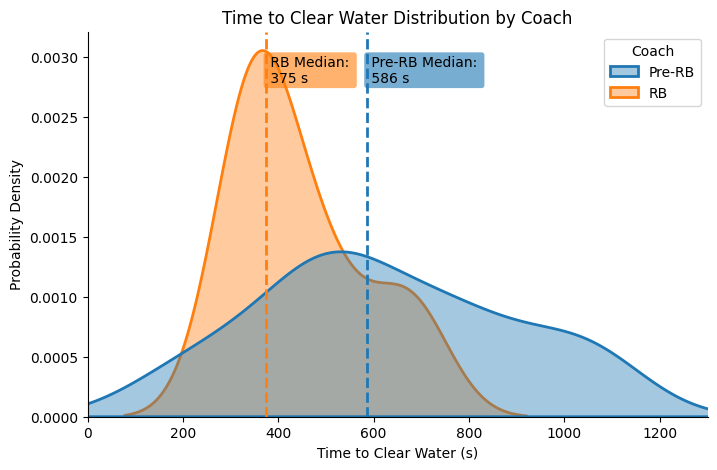

In [ ]:
import seaborn as sns

df_slice1 = data_with_weather_2001_dropped.iloc[0:18].copy()
df_slice2 = data_with_weather_2001_dropped.iloc[18:23].copy()

df_slice1["Coach"] = "Pre-RB"
df_slice2["Coach"] = "RB"
df_plot = pd.concat([df_slice1, df_slice2])

# Compute medians
medians = df_plot.groupby("Coach")["time_to_clear_water"].median()

# Define consistent palette
palette = sns.color_palette("tab10")
coach_palette = dict(zip(df_plot["Coach"].unique(), palette))

# Plot
plt.figure(figsize=(8, 5))
ax = sns.kdeplot(
    data=df_plot,
    x="time_to_clear_water",
    hue="Coach",
    fill=True,
    alpha=0.4,
    linewidth=2,
    common_norm=False,
    palette=coach_palette,
    bw_adjust=0.8
)

# Add median lines
for coach, median_val in medians.items():
    ax.axvline(median_val, color=coach_palette[coach], linestyle="--", linewidth=2)
    ax.text(
        median_val, ax.get_ylim()[1]*0.9,
        f" {coach} Median: \n {median_val:.0f} s",
        rotation=0,
        color="black",
        ha="left", va="center", fontsize=10, 
        bbox=dict(boxstyle="round,pad=0.2", facecolor=coach_palette[coach], alpha=0.6, edgecolor="none")
    )

plt.title("Time to Clear Water Distribution by Coach")
plt.xlabel("Time to Clear Water (s)")
plt.ylabel("Probability Density")
plt.xlim(0,1300)
sns.despine()
plt.show()


Density plots of time to clear water in pre-RB and post-RB era in minutes

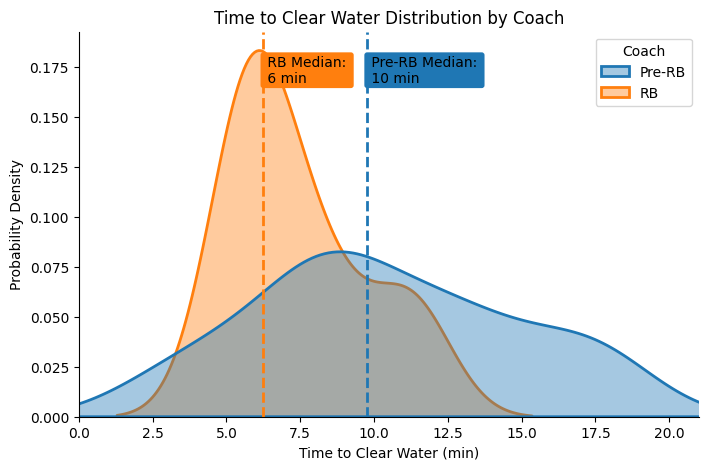

In [292]:
data_with_weather_2001_dropped["time_to_clear_water_min"] = data_with_weather_2001_dropped["time_to_clear_water"] / 60

df_slice1 = data_with_weather_2001_dropped.iloc[0:18].copy()
df_slice2 = data_with_weather_2001_dropped.iloc[18:23].copy()

df_slice1["Coach"] = "Pre-RB"
df_slice2["Coach"] = "RB"
df_plot = pd.concat([df_slice1, df_slice2])

# Compute medians
medians = df_plot.groupby("Coach")["time_to_clear_water_min"].median()

# Define consistent palette
palette = sns.color_palette("tab10")
coach_palette = dict(zip(df_plot["Coach"].unique(), palette))

# Plot
plt.figure(figsize=(8, 5))
ax = sns.kdeplot(
    data=df_plot,
    x="time_to_clear_water_min",
    hue="Coach",
    fill=True,
    alpha=0.4,
    linewidth=2,
    common_norm=False,
    palette=coach_palette,
    bw_adjust=0.8
)

# Add median lines
for coach, median_val in medians.items():
    ax.axvline(median_val, color=coach_palette[coach], linestyle="--", linewidth=2)
    ax.text(
        median_val, ax.get_ylim()[1]*0.9,
        f" {coach} Median: \n {median_val:.0f} min",
        rotation=0,
        color="black",
        ha="left", va="center", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor=coach_palette[coach], alpha=1, edgecolor="none") 
    )

plt.title("Time to Clear Water Distribution by Coach")
plt.xlabel("Time to Clear Water (min)")
plt.ylabel("Probability Density")
plt.xlim(0,21)
sns.despine()

plt.savefig(
    "time_to_clear_water_kde.png",   # or .pdf / .svg
    dpi=300,                    # dots per inch (300+ for print quality)
    bbox_inches="tight",        # trims extra whitespace
    facecolor="white",          # ensures background is solid white
    transparent=False
)

plt.show()


Compare the winning margins in the pre and post-RB eras

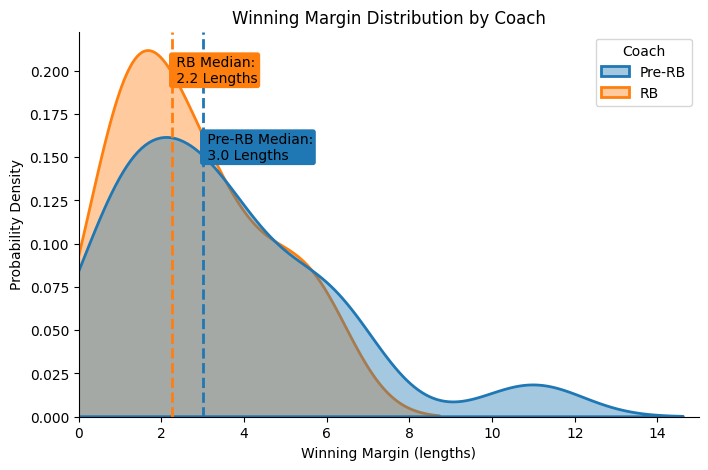

In [ ]:


df_slice1 = data_with_weather_2001_dropped.iloc[0:18].copy()
df_slice2 = data_with_weather_2001_dropped.iloc[18:23].copy()

df_slice1["Coach"] = "Pre-RB"
df_slice2["Coach"] = "RB"
df_plot = pd.concat([df_slice1, df_slice2])

# Compute medians
medians = df_plot.groupby("Coach")["margin"].median()

# Define consistent palette
palette = sns.color_palette("tab10")
coach_palette = dict(zip(df_plot["Coach"].unique(), palette))

# Plot
plt.figure(figsize=(8, 5))
ax = sns.kdeplot(
    data=df_plot,
    x="margin",
    hue="Coach",
    fill=True,
    alpha=0.4,
    linewidth=2,
    common_norm=False,
    palette=coach_palette,
    bw_adjust=0.8
)

offsets = {"Pre-RB": 0.7, "RB": 0.9}  # fraction of y-axis height

for coach, median_val in medians.items():
    y_pos = ax.get_ylim()[1] * offsets[coach]
    ax.axvline(median_val, color=coach_palette[coach], linestyle="--", linewidth=2)
    ax.text(
        median_val, y_pos,
        f" {coach} Median:\n {median_val:.1f} Lengths",
        rotation=0,
        color="black",
        ha="left", va="center", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor=coach_palette[coach], alpha=1.0, edgecolor="none")
    )


plt.title("Winning Margin Distribution by Coach")
plt.xlabel("Winning Margin (lengths)")
plt.ylabel("Probability Density")
plt.xlim(0,15)
sns.despine()

plt.savefig(
    "winning_margin_kde.png",   
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    transparent=False
)

plt.show()


Investigate influence of wind on station win probability.

Basically no influence

Optimization terminated successfully.
         Current function value: 0.688326
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             surrey_win   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                0.005599
Time:                        14:42:45   Log-Likelihood:                -15.831
converged:                       True   LL-Null:                       -15.921
Covariance Type:            nonrobust   LLR p-value:                    0.9147
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1954      0.537      0.364      0.716      -0.856

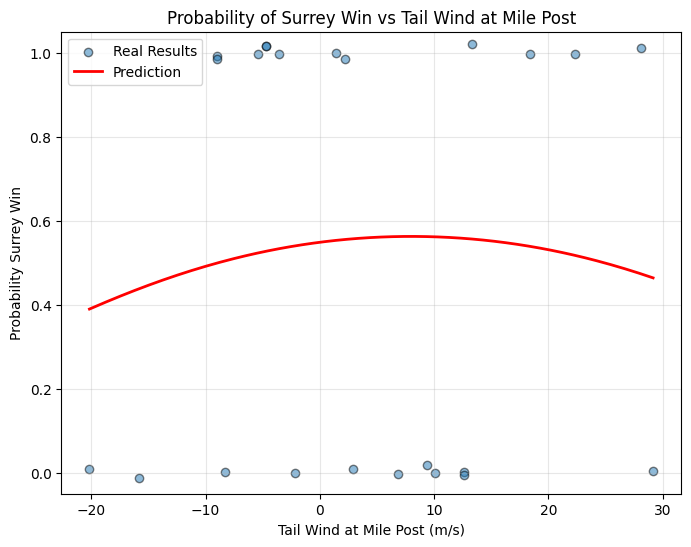

In [ ]:
df = data_with_weather_2001_dropped.copy()
df = df.dropna(subset=["wind_component_mile_post", "surrey_win"])

# Add quadratic term
df["wind2"] = df["wind_component_mile_post"] ** 2

# Logistic regression: Surrey win ~ wind + wind²
X = df[["wind_component_mile_post", "wind2"]]
X = sm.add_constant(X)
y = df["surrey_win"].astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

# Make smooth prediction curve
wind_range = np.linspace(df["wind_component_mile_post"].min(),
                         df["wind_component_mile_post"].max(), 200)
X_pred = pd.DataFrame({
    "const": 1,
    "wind_component_mile_post": wind_range,
    "wind2": wind_range**2
})
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))

# Raw data (jitter y a bit so points don't overlap)
plt.scatter(df["wind_component_mile_post"],
            df["surrey_win"] + np.random.uniform(-0.02, 0.02, size=len(df)),
            alpha=0.5, edgecolor="k", label="Real Results")

# Predicted probability curve
plt.plot(wind_range, y_pred, color="red", linewidth=2, label="Prediction")

plt.title("Probability of Surrey Win vs Tail Wind at Mile Post")
plt.xlabel("Tail Wind at Mile Post (m/s)")
plt.ylabel("Probability Surrey Win")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Maybe strong wind of either direction at start favours Middlesex

Optimization terminated successfully.
         Current function value: 0.646949
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             surrey_win   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                 0.06538
Time:                        15:13:24   Log-Likelihood:                -14.880
converged:                       True   LL-Null:                       -15.921
Covariance Type:            nonrobust   LLR p-value:                    0.3532
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5448      0.553      0.986      0.324      -0.539       1.

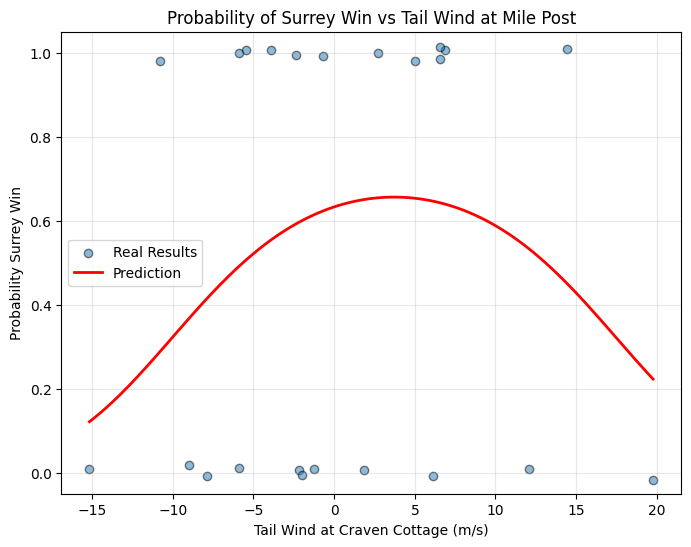

In [333]:
df = data_with_weather_2001_dropped.copy()
df = df.dropna(subset=["wind_component_craven", "surrey_win"])

# Add quadratic term
df["wind2"] = df["wind_component_craven"] ** 2

# Logistic regression: Surrey win ~ wind + wind²
X = df[["wind_component_craven", "wind2"]]
X = sm.add_constant(X)
y = df["surrey_win"].astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

# Make smooth prediction curve
wind_range = np.linspace(df["wind_component_craven"].min(),
                         df["wind_component_craven"].max(), 200)
X_pred = pd.DataFrame({
    "const": 1,
    "wind_component_craven": wind_range,
    "wind2": wind_range**2
})
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))

# Raw data (jitter y a bit so points don't overlap)
plt.scatter(df["wind_component_craven"],
            df["surrey_win"] + np.random.uniform(-0.02, 0.02, size=len(df)),
            alpha=0.5, edgecolor="k", label="Real Results")

# Predicted probability curve
plt.plot(wind_range, y_pred, color="red", linewidth=2, label="Prediction")

plt.title("Probability of Surrey Win vs Tail Wind at Mile Post")
plt.xlabel("Tail Wind at Craven Cottage (m/s)")
plt.ylabel("Probability Surrey Win")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Optimization terminated successfully.
         Current function value: 0.683582
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             surrey_win   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                 0.01245
Time:                        15:15:54   Log-Likelihood:                -15.722
converged:                       True   LL-Null:                       -15.921
Covariance Type:            nonrobust   LLR p-value:                    0.5289
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5776      0.892      0.648      0.517      -1.170       2.325
wind_speed    -0.0320      0.

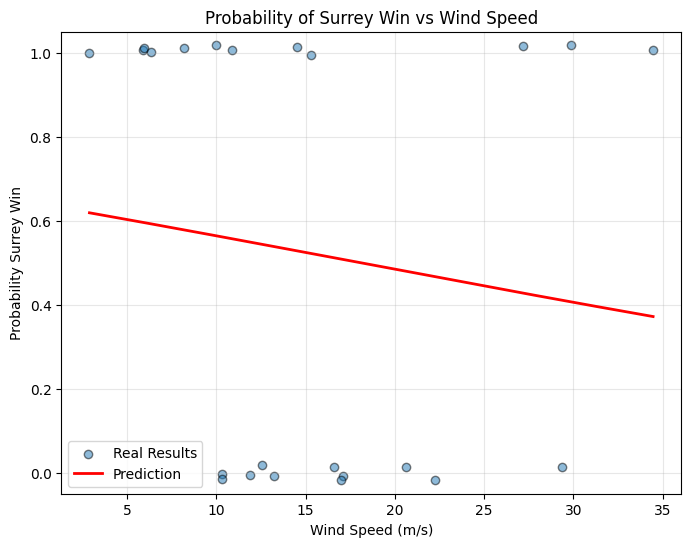

In [334]:
df = data_with_weather_2001_dropped.copy()
df = df.dropna(subset=["wind_speed", "surrey_win"])



# Logistic regression: Surrey win ~ wind + wind²
X = df[["wind_speed"]]
X = sm.add_constant(X)
y = df["surrey_win"].astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

# Make smooth prediction curve
wind_range = np.linspace(df["wind_speed"].min(),
                         df["wind_speed"].max(), 200)
X_pred = pd.DataFrame({
    "const": 1,
    "wind_speed": wind_range,
})
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))

# Raw data (jitter y a bit so points don't overlap)
plt.scatter(df["wind_speed"],
            df["surrey_win"] + np.random.uniform(-0.02, 0.02, size=len(df)),
            alpha=0.5, edgecolor="k", label="Real Results")

# Predicted probability curve
plt.plot(wind_range, y_pred, color="red", linewidth=2, label="Prediction")

plt.title("Probability of Surrey Win vs Wind Speed")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Probability Surrey Win")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Investigate effect of fast start vs probability of Surrey win

This shows that races which start fast tend to be won by the Middlesex crew

Therefore, if you win the toss and back yourself to go out hard, you should pick Middlesex.

Another interpretation is that races in which the Middlesex crew wins tend to be 'over' quickly, and therefore have larger FSFs, but there doesn't seem to be a negative correlation between FSF and time to clear water, which contradicts this interpretation.

Optimization terminated successfully.
         Current function value: 0.498445
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             surrey_win   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                  0.2799
Time:                        14:53:21   Log-Likelihood:                -11.464
converged:                       True   LL-Null:                       -15.921
Covariance Type:            nonrobust   LLR p-value:                  0.002832
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

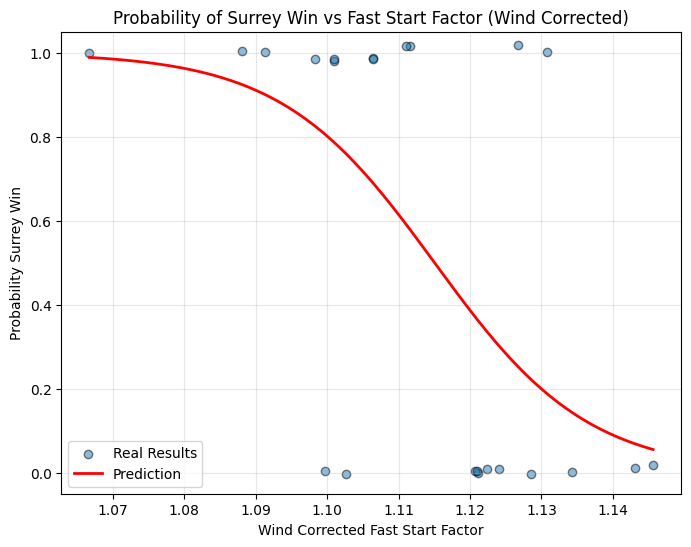

In [328]:
df = data_with_weather_2001_dropped.copy()
df = df.dropna(subset=["fast_start_factor_mile_post_wind_corrected", "surrey_win"])


X = df[["fast_start_factor_mile_post_wind_corrected"]]
X = sm.add_constant(X)
y = df["surrey_win"].astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

# Make smooth prediction curve
fsf_range = np.linspace(df["fast_start_factor_mile_post_wind_corrected"].min(),
                         df["fast_start_factor_mile_post_wind_corrected"].max(), 200)
X_pred = pd.DataFrame({
    "const": 1,
    "fast_start_factor_mile_post_wind_corrected": fsf_range,

})
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))

# Raw data (jitter y a bit so points don't overlap)
plt.scatter(df["fast_start_factor_mile_post_wind_corrected"],
            df["surrey_win"] + np.random.uniform(-0.02, 0.02, size=len(df)),
            alpha=0.5, edgecolor="k", label="Real Results")

# Predicted probability curve
plt.plot(fsf_range, y_pred, color="red", linewidth=2, label="Prediction")

plt.title("Probability of Surrey Win vs Fast Start Factor (Wind Corrected)")
plt.xlabel("Wind Corrected Fast Start Factor")
plt.ylabel("Probability Surrey Win")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Investigate influence of time to clear water on probability of Surrey win.

No significant effect

Optimization terminated successfully.
         Current function value: 0.619559
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             surrey_win   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                  0.1049
Time:                        15:11:17   Log-Likelihood:                -14.250
converged:                       True   LL-Null:                       -15.921
Covariance Type:            nonrobust   LLR p-value:                   0.06755
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.0291      1.232      1.647      0.100      -0.385       4.443
ti

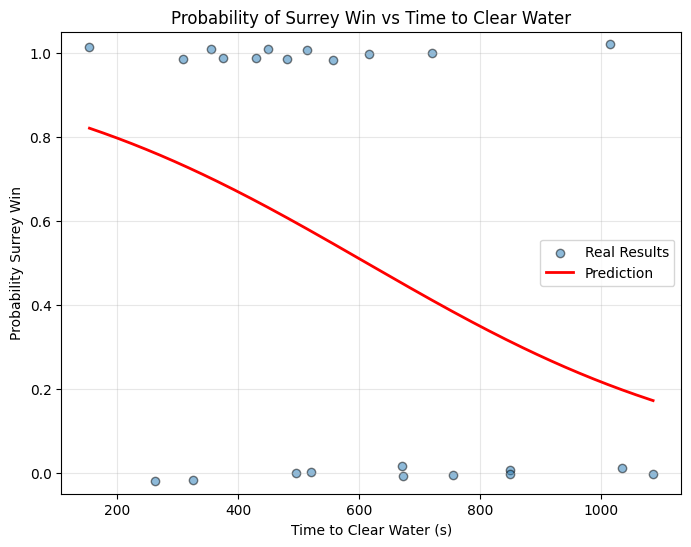

In [332]:
df = data_with_weather_2001_dropped.copy()
df = df.dropna(subset=["time_to_clear_water", "surrey_win"])


X = df[["time_to_clear_water"]]
X = sm.add_constant(X)
y = df["surrey_win"].astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

# Make smooth prediction curve
ttcw_range = np.linspace(df["time_to_clear_water"].min(),
                         df["time_to_clear_water"].max(), 200)
X_pred = pd.DataFrame({
    "const": 1,
    "time_to_clear_water": ttcw_range,

})
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))

plt.scatter(df["time_to_clear_water"],
            df["surrey_win"] + np.random.uniform(-0.02, 0.02, size=len(df)),
            alpha=0.5, edgecolor="k", label="Real Results")

# Predicted probability curve
plt.plot(ttcw_range, y_pred, color="red", linewidth=2, label="Prediction")

plt.title("Probability of Surrey Win vs Time to Clear Water")
plt.xlabel("Time to Clear Water (s)")
plt.ylabel("Probability Surrey Win")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Question: in light of the increased chances of a Middlesex win with a high FCF, does Cambridge choose M more often in the RB era?